# Offensive Rebounds vs Shot Distance

When a player takes a shot in the NBA, if the shot does not go in, either team (shooting team, or non-shooting team) can gain possession of the ball. If the non-shooting team gets the rebound (“defensive rebound”) they proceed to the other end of the court to try and make a basket. If the shooting team gets the rebound (“offensive rebound” and generally rarer) then they can try to shoot again. 

In recent years the NBA has undergone a change, focusing more on “transition offense”. That is getting a defensive rebound and pushing the ball up the court as fast a possible to score in transition. Playing fast allows the offensive team to get up the court before the defense has a chance to organize itself. 

With this change, some teams have opted to run back on defense and forego offensive rebounds, while other have opted to try to “crash the boards” and keep possesion. This is all further complicated by the fact that 3-pt shooting is on an upward trend.

Some simple questions I wanted to explore are:
1. Does the advent of the increased 3-pt shooting era lead to more offensive rebounds?
2. Which teams are looking for offensive rebounds and does this correlate with teams which focus more on 3pt shots?
3. Historically how is this trend evolving?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests

Why re-invent the wheel? Swar Patel already put together a nice package to extract and aquire the 
data from the stats.nba.com API endpoints (https://github.com/swar/nba_api) 

This snippet find the team_id used by the API to acquire all the game information. In this case I am looking at the 
data from the Oklahoma City Thunder because they are currently considered a good rebounding team

In [2]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()
okc = [team for team in nba_teams if team['abbreviation'] == 'OKC'][0]
thunder_id = okc['id']

Next extract and return a dataframe with all the games since 2000

In [3]:
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=thunder_id)
games = gamefinder.get_data_frames()[0]
games.groupby(games.SEASON_ID.str[-4:])[['GAME_ID']].count().loc['2000':]

,GAME_ID
SEASON_ID,
2000,82
2001,87
2002,82
2003,83
2004,96
2005,89
2006,90
2007,94
2008,89


Now I'm going to keep a list of all the games for a particular season. This will be useful as I won't have to go back to  get them later. In this case, the final list "games_to_keep" will contain the years in each index. That is 
entry 0 contains the year 2000's games, entry 18 contains the year 2018's games

In [4]:
def get_games(year):
    games_keep= games[(games.SEASON_ID.str[-4:] == year)]
    games_keep= games_keep.reset_index(drop=True)
    return games_keep

In [5]:
games_to_keep = []
for i in range(2000,2019):
    games_to_keep.append(get_games(str(i)))
    
# This is a list with all games in the year
# i.e entry 0 contains the year 2000, entry 18 contains the year 2018 
games_to_keep[18].shape

(91, 28)

Next we want to loop over all games in the list, and then get the play-by-play data. 
We want to extract and keep only *important* information. This involves combing through the data to get only the 
shooting and rebound data, saving the info about the team, offensive rebounds, distance, shooting percentages, and 3pt shoooting percentages. 

An example before the loop shows what this play-by-play data looks like.



In [6]:
from nba_api.stats.endpoints import playbyplayv2
from time import sleep
from dateutil import parser


first_game = games_to_keep[18]['GAME_ID'].iloc[0]
pbp = playbyplayv2.PlayByPlayV2(first_game)
pbp = pbp.get_data_frames()[0]
pbp.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION
0,0021801226,2,12,0,1,8:11 PM,12:00,None,None,None,...,None,None,None,0,0,None,NaN,None,None,None
1,0021801226,4,10,0,1,8:11 PM,12:00,Jump Ball Wilson vs. Adams: Tip to Grant,None,None,...,Oklahoma City,Thunder,OKC,5,203924,Jerami Grant,1.610613e+09,Oklahoma City,Thunder,OKC
2,0021801226,7,2,67,1,8:12 PM,11:39,None,None,MISS Adams 2' Hook Bank Shot,...,None,None,None,0,0,None,NaN,None,None,None
3,0021801226,8,4,0,1,8:12 PM,11:37,Middleton REBOUND (Off:0 Def:1),None,None,...,None,None,None,0,0,None,NaN,None,None,None
4,0021801226,9,1,98,1,8:12 PM,11:21,Wilson 2' Cutting Layup Shot (2 PTS) (Middleto...,None,None,...,Milwaukee,Bucks,MIL,0,0,None,NaN,None,None,None


In [7]:
# Create new dataframe with only relevant information of individual game data

def get_all_season(gtk):
    season = pd.DataFrame(columns=['TEAM','SEA','OREBS', '0-8ft', '8-16ft','16-24ft', '24ft',
                                  '3PTPER','3PTSHOTPER', 'OREBPER', 'MISS3PTPER'])

    num_games = len(gtk.index)
    for index, row in gtk.iterrows():
        if(index % 10 == 0):
            print "parsed " + str(index) + " of " + str(num_games) + " games" 
        
    # Get the current game play-by-play data    
        current_game = gtk['GAME_ID'].iloc[index]
        date_game = gtk['GAME_DATE'].iloc[index]
        date_game = parser.parse(date_game).strftime("%m-%d-%Y")
        date_game=date_game[:-4]+date_game[-2:]
        sea =float(gtk.SEASON_ID.str[-4:].iloc[index])
        #del pbp
        pbp = playbyplayv2.PlayByPlayV2(current_game)
        pbp = pbp.get_data_frames()[0]
        pbp = pbp.drop(columns=['GAME_ID', 'WCTIMESTRING','NEUTRALDESCRIPTION', 'PERIOD','PCTIMESTRING',
          'SCORE', 'SCOREMARGIN',
          'PERSON1TYPE','PLAYER1_NAME','PLAYER1_ID','PLAYER1_TEAM_ID',
          'PLAYER1_TEAM_CITY','PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION',
          'PERSON2TYPE','PLAYER2_NAME','PLAYER2_ID','PLAYER2_TEAM_ID',
          'PLAYER2_TEAM_CITY','PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION',
          'PERSON3TYPE','PLAYER3_NAME','PLAYER3_ID','PLAYER3_TEAM_ID',
          'PLAYER3_TEAM_CITY','PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION'], axis=1)    


        # Figure out which teams' shots we want 
        desired_team = 'HOMEDESCRIPTION' 
        other_team  = 'VISITORDESCRIPTION' 
        if('@' in gtk['MATCHUP'].iloc[index]):
            desired_team = 'VISITORDESCRIPTION' 
            other_team = 'HOMEDESCRIPTION' 
    
        # Store relevant info from both pbp data and game data 
        opp = str(gtk['MATCHUP'].iloc[index]).split()[-1] + "\n"+ date_game
        orebs = gtk['OREB'].iloc[index]
        tpp = gtk['FG3_PCT'].iloc[index]
        tpsp = float(gtk['FG3A'].iloc[index]) / float(gtk['FGA'].iloc[index])
        oper = float(gtk['OREB'].iloc[index]) /  float(gtk['FGA'].iloc[index] - gtk['FGM'].iloc[index])
        tpspm =  float(gtk['FG3A'].iloc[index] - gtk['FG3M'].iloc[index] ) /  float(gtk['FGA'].iloc[index] - gtk['FGM'].iloc[index])

    
        #Get all relevant shots, organize by distance, etc
        event_shots = (pbp[pbp[desired_team].str.contains("REBOUND") == True]['EVENTNUM']-1).tolist()
        pbp = pbp[pbp['EVENTNUM'].isin(event_shots)]
        pbp = pbp[pbp[other_team].isnull()]
    
        pbp['distance'] = pbp[desired_team].str.extract('([0-9]+)\'', expand = False)
        pbp['distance'] = pd.to_numeric(pbp['distance'], errors='coerce')
        
        pbp['shot_d_cat'] = 1
        pbp.loc[pbp['distance'] > 8, 'shot_d_cat'] = 2
        pbp.loc[pbp['distance'] > 16, 'shot_d_cat'] = 3
        pbp.loc[pbp['distance'] > 24, 'shot_d_cat'] = 4
        pbp.loc[pbp[desired_team].str.contains("3PT") == True, 'shot_d_cat'] = 4
        pbp.fillna(0.0)
       
        short = len(pbp[(pbp['shot_d_cat']==1)])
        mid = len(pbp[(pbp['shot_d_cat']==2)]) + short
        lon = len(pbp[(pbp['shot_d_cat']==3)]) + mid
        three =  len(pbp[(pbp['shot_d_cat']==4)]) 
   
        # Add to new dataframe of individual game data
        df_game = pd.DataFrame([[opp,sea,orebs,short,mid,lon,three,tpp, tpsp, oper, tpspm]],
                           columns=['TEAM', 'SEA', 'OREBS', '0-8ft','8-16ft','16-24ft','24ft',
                                    '3PTPER','3PTSHOTPER','OREBPER', 'MISS3PTPER'])
        season = pd.concat([df_game,season], sort=False)
        
    
        #Hacky part right now to allow requests from API to not hang up.
        if(index % 5 == 0):
            sleep(2)
    # Remove preseason games (Games in July, August, September)
    season = season[(season['TEAM'].str.contains("\n07") == False) 
                 & (season['TEAM'].str.contains("\n08") == False) 
                 & (season['TEAM'].str.contains("\n09") == False)]
    season['3PTOREBPER'] = season['24ft'].astype(float) / season['OREBS'].astype(float)
    season['SEA'] = season['SEA'].astype(int)
    return season


Get games from 2000 and 2018 season, and keep them in a dictionary. Now when I call the dictionary, it returns a dataframe with the game information, for a particular season. 
This dataframe has the following stats thatI think will be useful to analyze:

1. team 
2. season
3. Number of offensive rebounds in game
4. **Offensive rebounds when shot was taken from 0-8 feet**
5. **Offensive rebounds when shot was taken from 8-16 feet**
6. **Offensive rebounds when shot was taken from 16-24 feet**
7. **Offensive rebounds when shot was taken from 24+ feet**
8. 3 point field goal percentage (3PTPER)
9. **Percentage of shots that were 3 point field goal attempts (3PTSHOTPER)**
10. **Percentage of offensive rebounds coming from 3 point attemphs (3PTOREBPER)**
11. **Percentage of shots which results in an offensive rebound ( OREBPER)**
12. **Pecentage of missed shots which were 3 point field goal attempts (MISS3PTPER)**

In [8]:
game_dfs = {}
for i in range(0,19):
    if(i < 10):
        s = '0' + str(i)
    else:
        s = str(i)
    print 'getting season 20' + s + '\n'
    game_dfs['sea_'+s] = get_all_season(games_to_keep[i])
    sleep(10)

getting season 2000

parsed 0 of 82 games
parsed 10 of 82 games
parsed 20 of 82 games
parsed 30 of 82 games
parsed 40 of 82 games
parsed 50 of 82 games
parsed 60 of 82 games
parsed 70 of 82 games
parsed 80 of 82 games
getting season 2001

parsed 0 of 87 games
parsed 10 of 87 games
parsed 20 of 87 games
parsed 30 of 87 games
parsed 40 of 87 games
parsed 50 of 87 games
parsed 60 of 87 games
parsed 70 of 87 games
parsed 80 of 87 games
getting season 2002

parsed 0 of 82 games
parsed 10 of 82 games
parsed 20 of 82 games
parsed 30 of 82 games
parsed 40 of 82 games
parsed 50 of 82 games
parsed 60 of 82 games
parsed 70 of 82 games
parsed 80 of 82 games
getting season 2003

parsed 0 of 83 games
parsed 10 of 83 games
parsed 20 of 83 games
parsed 30 of 83 games
parsed 40 of 83 games
parsed 50 of 83 games
parsed 60 of 83 games
parsed 70 of 83 games
parsed 80 of 83 games
getting season 2004

parsed 0 of 96 games
parsed 10 of 96 games
parsed 20 of 96 games
parsed 30 of 96 games
parsed 40 of 96 game

In [9]:
sea_00 = game_dfs['sea_00']
sea_18 = game_dfs['sea_18']
both = pd.concat([sea_00,sea_18], axis=0)
both.head()

,TEAM,SEA,OREBS,0-8ft,8-16ft,16-24ft,24ft,3PTPER,3PTSHOTPER,OREBPER,MISS3PTPER,3PTOREBPER
0,VAN\n10-31-00,2000,14,7,8,9,4,0.348,0.273810,0.269231,0.288462,0.285714
0,DEN\n11-01-00,2000,10,3,6,6,2,0.417,0.151899,0.285714,0.200000,0.200000
0,POR\n11-04-00,2000,11,5,7,7,2,0.125,0.213333,0.250000,0.318182,0.181818
0,ORL\n11-06-00,2000,17,7,9,12,4,0.292,0.269663,0.346939,0.346939,0.235294
0,MIA\n11-08-00,2000,9,3,6,7,2,0.375,0.225352,0.230769,0.256410,0.222222


For starters let's compare the 2000 season and the 2018 season. 
Lets' just look at one team. OKC vs Houston rockets, a team known for shooting 3 pointers. The plot below shows us that the number of offensive rebounds coming from 3pt attempts is on the rise. But that could just be from an increase in 3pt shooting

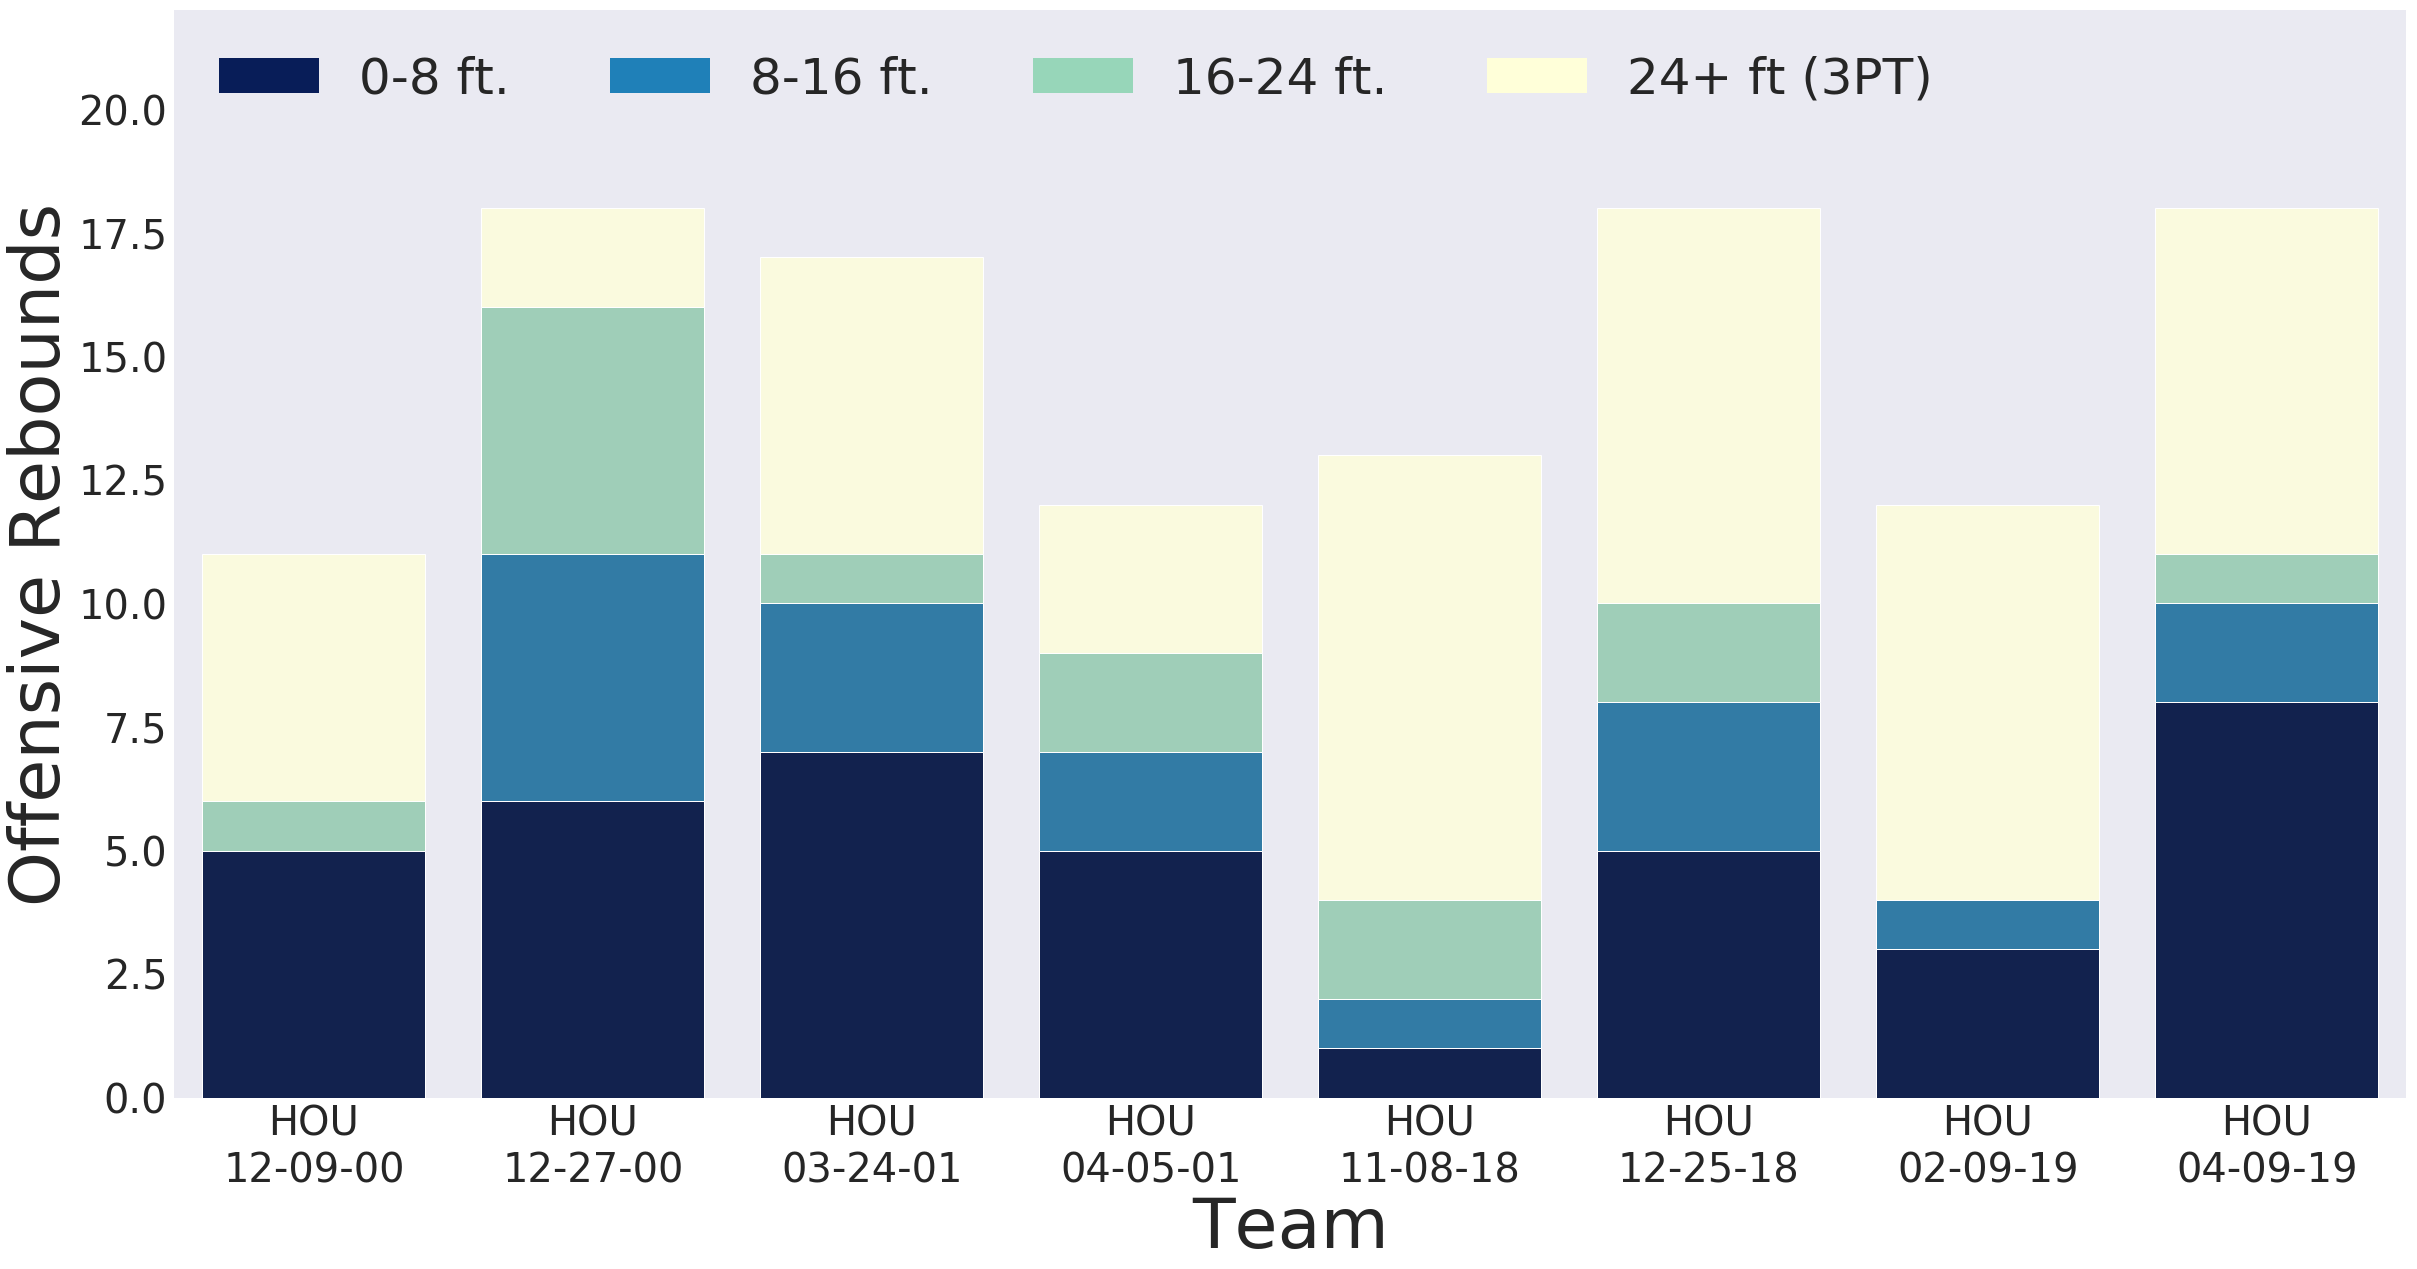

In [10]:
from matplotlib import pyplot as plt
from matplotlib import cm 

import seaborn as sns
sns.set_style("dark")
sns.set_color_codes()
plt.figure(figsize=(40,20))

hou = both[both['TEAM'].str.contains("HOU") == True]

color1=iter(cm.YlGnBu(np.linspace(0,1,4)))

c=next(color1)

sns.barplot(x = hou['TEAM'], y = hou['OREBS'],  color=c)
three_bar = plt.Rectangle((0,0),1,1,fc=c, edgecolor = 'none')
c=next(color1)

long_plot = sns.barplot(x = hou['TEAM'], y = hou['16-24ft'], color=c)
long_bar = plt.Rectangle((0,0),1,1,fc=c,  edgecolor = 'none')
c=next(color1)

mid_plot = sns.barplot(x = hou['TEAM'], y = hou['8-16ft'], color=c)
mid_bar = plt.Rectangle((0,0),1,1,fc=c, edgecolor = 'none')
c=next(color1)

short_plot = sns.barplot(x = hou['TEAM'], y = hou['0-8ft'], color=c)
short_bar = plt.Rectangle((0,0),1,1,fc=c,  edgecolor = 'none')

l = plt.legend([short_bar, mid_bar,long_bar,three_bar],
               ['0-8 ft.', '8-16 ft.','16-24 ft.', '24+ ft (3PT)'], loc=2, ncol = 4, prop={'size':50})
l.draw_frame(False)

sns.despine(left=True)
short_plot.set_ylabel("Offensive Rebounds")
short_plot.set_xlabel("Team")
short_plot.set(ylim=(0, 22))

for item in ([short_plot.xaxis.label, short_plot.yaxis.label] +
             short_plot.get_xticklabels() + short_plot.get_yticklabels()):
    item.set_fontsize(40)
for item in ([short_plot.xaxis.label, short_plot.yaxis.label]):
    item.set_fontsize(70)

In [11]:
def format_plot(plot):
    plt.setp(plot.get_legend().get_texts(), fontsize='22') 
    for item in (plot.get_xticklabels() + plot.get_yticklabels()):
        item.set_fontsize(20)
    for item in ([plot.xaxis.label, plot.yaxis.label]):
        item.set_fontsize(40)

Now, if my hypothesis was correct, then as teams shoot more three pointer, they would get more offensive rebounds. There is some correlation.But for now let's move on.

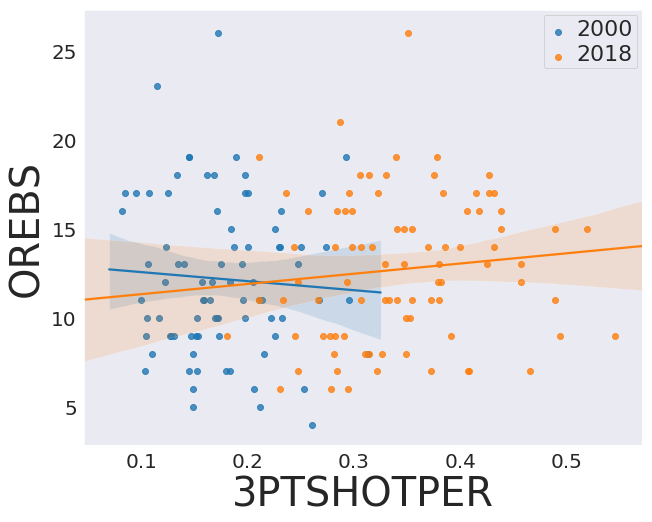

In [29]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

plt.figure(figsize=(10,8))

x=sea_00['3PTSHOTPER'].astype(float)
y=sea_00['OREBS'].astype(float)
sns.regplot(x,y, label = '2000')

x2=sea_18['3PTSHOTPER'].astype(float)
y2=sea_18['OREBS'].astype(float)
plot_2 = sns.regplot(x2,y2, label='2018')

plot_2.legend()
format_plot(plot_2)


If you have two Gaussian distributions, you can calculate the overlaping area as follows:

Two Gaussians:

$$ G(\mu_1, \sigma^2_1)$$
$$ G(\mu_2, \sigma^2_2)$$ 

with means $\mu$ and standard deviations $\sigma$. Since we know the form of the Gaussians, one can calculate the 
intercept point, p,  of them as:

$$p=\frac{\mu_{2} \sigma_{1}^{2}-\sigma_{2}\left(\mu_{1} \sigma_{2}+\sigma_{1} \sqrt{\left(\mu_{1}-\mu_{2}\right)^{2}+2\left(\sigma_{1}^{2}-\sigma_{2}^{2}\right) \log \left(\frac{\sigma_{1}}{\sigma_{2}}\right)}\right)}{\sigma_{1}^{2}-\sigma_{2}^{2}}$$

and then the area as:

$$\frac{1}{2} \operatorname{erf}\left(\frac{p-\mu_{1}}{\sqrt{2} \sigma_{1}}\right) + \left(1-\frac{1}{2} \operatorname{erf}\left(\frac{p-\mu_{2}}{\sqrt{2} \sigma_{2}}\right)\right)$$ 





In [60]:
from scipy.stats import norm, ks_2samp, kstest
from scipy import special, integrate

def make_dist_plot(var):
    
    plt.figure(figsize=(12,8))
    sea_18[var] = sea_18[var].astype(float)
    sea_00[var] = sea_00[var].astype(float)
    plot1 = sns.distplot(sea_00[var], label='2000', norm_hist= True, fit=norm, kde=False, fit_kws={"color":"darkblue"})
    plot2 = sns.distplot(sea_18[var], label='2018', norm_hist= True, fit=norm, kde=False, fit_kws={"color":"darkorange"})
    plot2.set_ylabel("A.U.")
    plot2.legend()
    format_plot(plot2)
    return plot2  

def get_intersect(mu1, mu2, sig1, sig2):
    
    sq = np.sqrt(np.power((mu1-mu2),2) + 2*((np.power(sig1,2)-np.power(sig2,2))*np.log(sig1/sig2)))
    numerator = mu2*(np.power(sig1,2)) - sig2*(mu1*sig2 + sig1*sq)
    denominator = np.power(sig1,2)-np.power(sig2,2)
    return numerator/denominator

def get_intersect_area(intersect, mu1, mu2, sig1, sig2):
    
    t1 = (intersect - mu1)/(np.sqrt(2)*sig1)
    t2 = (intersect - mu2)/(np.sqrt(2)*sig2)
    area1 = 0.5*special.erfc(t1)
    area2 = 1 - 0.5*special.erfc(t2)

    return area1 + area2 
    

def find_x_tail(frac, p, var):
    
    x,y = p.get_lines()[0].get_data()
    cdf = integrate.cumtrapz(y, x, initial=0)
    nearest = np.abs(cdf-(1-frac)).argmin()
    x_val = x[nearest]
    y_val = y[nearest]
    plt.vlines(x_val, 0, y_val, color='red')
    
    x1,y1 = p.get_lines()[1].get_data()
    cdf = integrate.cumtrapz(y1, x1, initial=0)
    nearest = np.abs(cdf-(1-frac)).argmin()
    x1_val = x1[nearest]
    y1_val = y1[nearest]
    
    plt.vlines(x1_val, 0, y1_val, color='green')
    
    mu1, sig1 = stats.norm.fit(sea_00[var]) 
    mu2, sig2 = stats.norm.fit(sea_18[var])
    inter  = get_intersect(mu1, mu2, sig1, sig2)
    area = get_intersect_area(inter, mu1, mu2, sig1, sig2)
    
    p.vlines(inter, 0, 5, color='purple')
    plt.show()
    
    print_ks_values(var)
    
    return x_val, x1_val, inter, area 

def print_ks_values(var):
    se00 = sea_00[var].values
    k00, p00 = kstest(rvs=se00, cdf='norm', args=(np.mean(se00), np.std(se00)))
    se18 = sea_18[var].values
    k18, p18 = kstest(rvs=se18, cdf='norm', args=(np.mean(se18), np.std(se18)))
    print "ks 2000:  " , k00 , "p-value 2000:  " , p00
    print "ks 2018:  " , k18 , "p-value 2018:  " , p18 
    k2, p2 = ks_2samp(se00, se18)
    print "ks 2samp: " , k2 , "p-value 2samp: " , p2
    return 
    

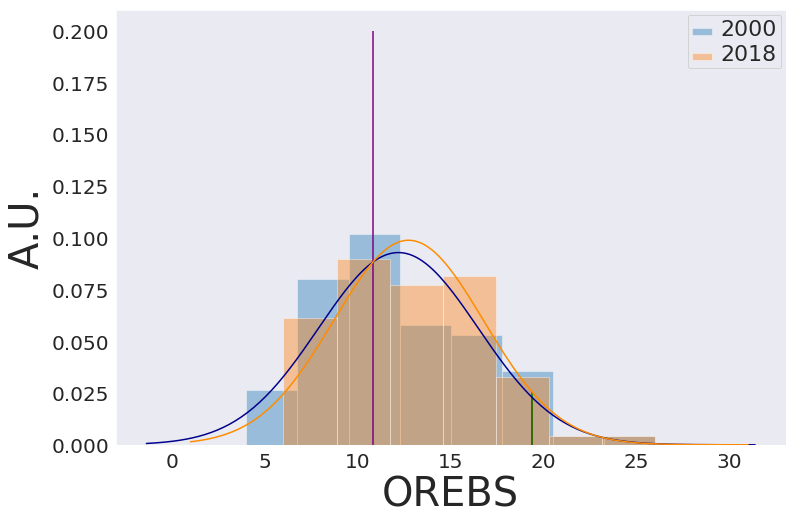

ks 2000:   0.12064224044568345 p-value 2000:   0.16935807821794868
ks 2018:   0.10137003150923163 p-value 2018:   0.31934761574889947
ks 2samp:  0.10011344299489511 p-value 2samp:  0.7726590962649857


In [59]:
p = make_dist_plot('OREBS')
x1, x2, inter, area = find_x_tail(0.05, p, 'OREBS')

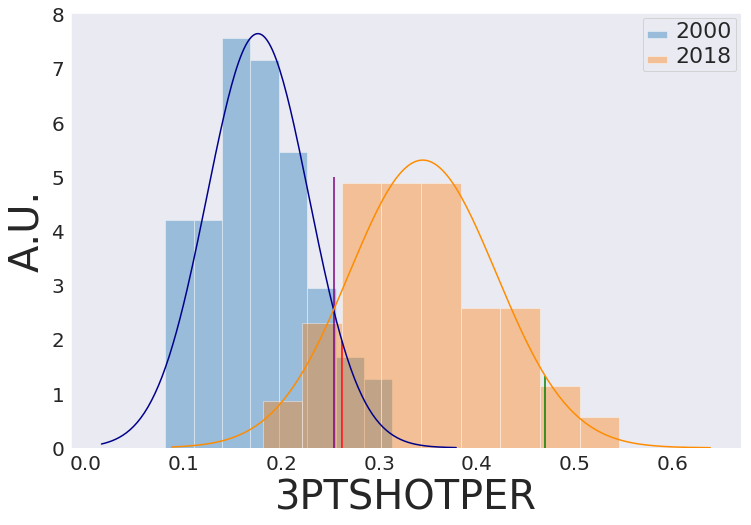

ks 2000:   0.06928739665352468 p-value 2000:   0.826025286655245
ks 2018:   0.06185419662058522 p-value 2018:   0.8971780472888276
ks 2samp:  0.8315371525808282 p-value 2samp:  1.0310986975267933e-26
area of overlap is:  0.1817321375142411


In [64]:
p = make_dist_plot('3PTSHOTPER')
x1, x2, inter, area = find_x_tail(0.05, p, '3PTSHOTPER')
print "area of overlap is: ", area

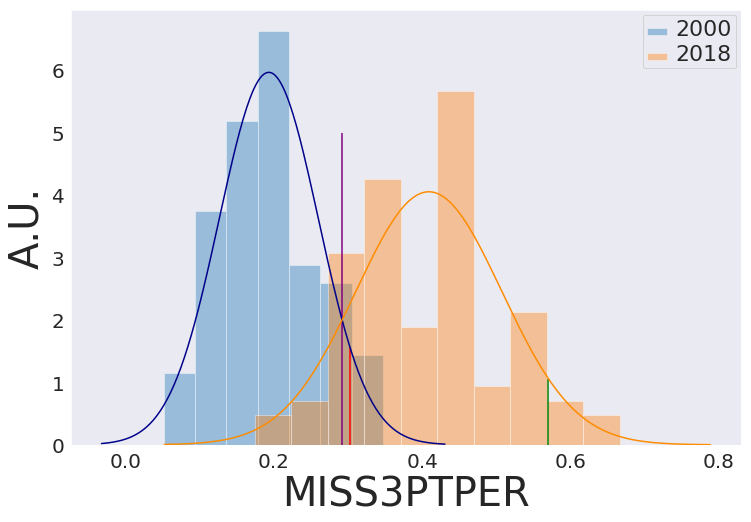

ks 2000:   0.05528959187786109 p-value 2000:   0.9635160372392148
ks 2018:   0.07415462414152418 p-value 2018:   0.7402076089368945
ks 2samp:  0.8564946114577425 p-value 2samp:  2.5801128938588397e-28
area of overlap is:  0.18700582889747894


In [62]:
p = make_dist_plot('MISS3PTPER')
x1, x2, inter, area  = find_x_tail(0.05, p, 'MISS3PTPER')
print "area of overlap is: ", area

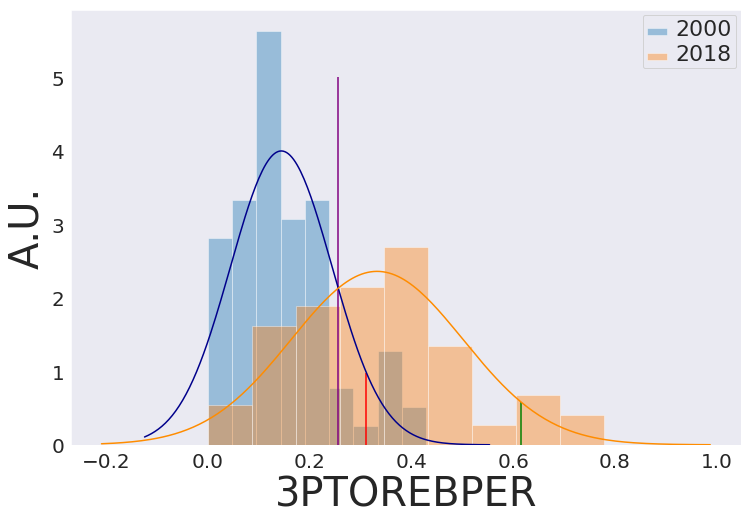

ks 2000:   0.11428718301677476 p-value 2000:   0.21745621765573508
ks 2018:   0.06201754065125553 p-value 2018:   0.8954059491229291
ks 2samp:  0.5635280771412365 p-value 2samp:  1.6899428128286266e-12
area of overlap is:  0.45677823713425564


In [65]:
p = make_dist_plot('3PTOREBPER')
x1, x2, inter, area  = find_x_tail(0.05, p, '3PTOREBPER')
print "area of overlap is: ", area

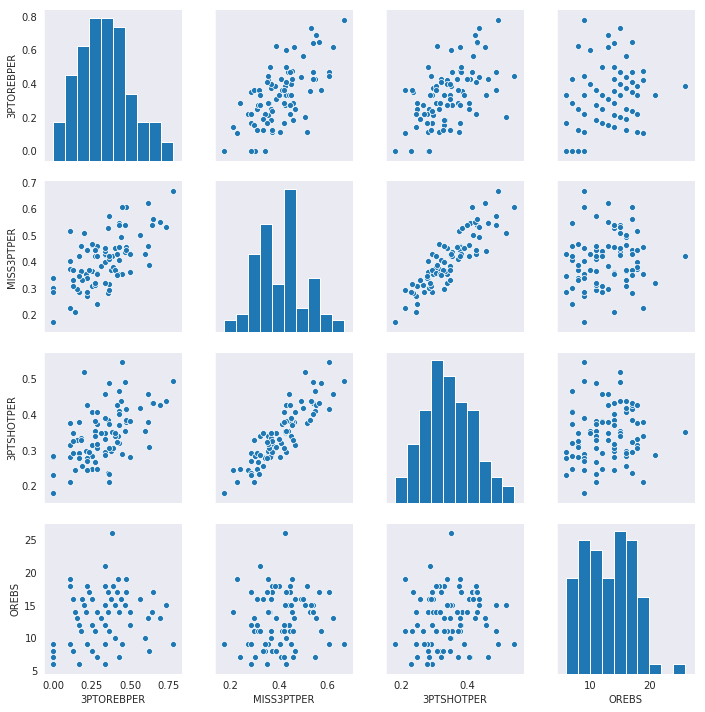

In [18]:
sns.pairplot(sea_18[['3PTOREBPER', 'MISS3PTPER', '3PTSHOTPER', 'OREBS']])

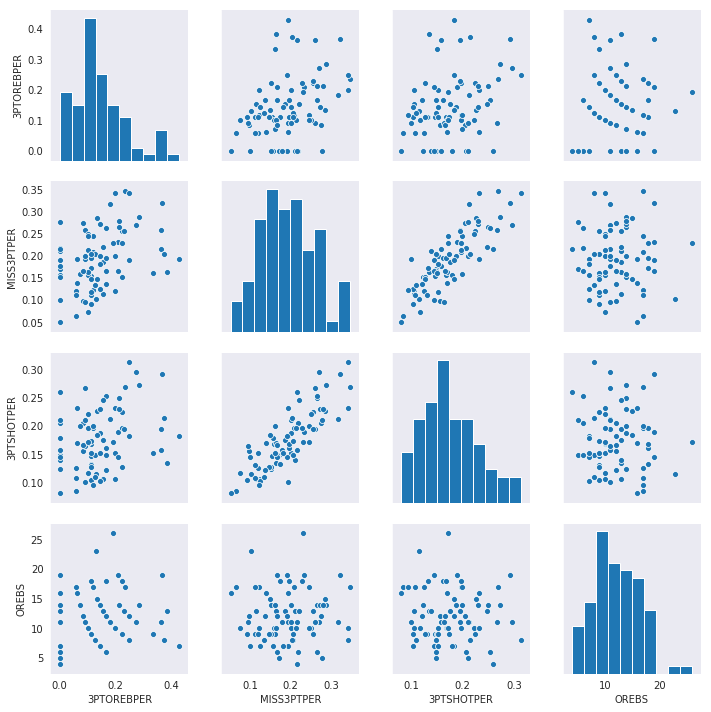

In [19]:
sns.pairplot(sea_00[['3PTOREBPER', 'MISS3PTPER', '3PTSHOTPER', 'OREBS']])

Now, we have found that some of the distributions are pretty seperated. Let's do something really silly and learn about sklearn classifiers. Using logistic regression. Uses labeled data to classify other data into binary classifications

Defines a logit

$$\operatorname{logit}(p)=b_{0}+b_{1} X_{1}+b_{2} X_{2}+b_{3} X_{3}+\ldots+b_{k} X_{k}$$

or 

$$ 
\operatorname{logit}(p)=\ln \left(\frac{p}{1-p}\right)
 $$
 
 where p is the probability for category to be 1 , and 1-p is probability for category 0, B's are coeffeicents of the model and Xs are the input parameters

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()
columns = ['3PTOREBPER', 'MISS3PTPER', '3PTSHOTPER', 'OREBS']

train = both
train.tail()

,TEAM,SEA,OREBS,0-8ft,8-16ft,16-24ft,24ft,3PTPER,3PTSHOTPER,OREBPER,MISS3PTPER,3PTOREBPER
0,LAL\n04-02-19,2018,17,3,5,6,11,0.295,0.431373,0.309091,0.563636,0.647059
0,DET\n04-05-19,2018,21,8,9,10,7,0.414,0.287129,0.396226,0.320755,0.333333
0,MIN\n04-07-19,2018,14,4,4,5,6,0.412,0.369565,0.318182,0.454545,0.428571
0,HOU\n04-09-19,2018,18,8,10,11,4,0.390,0.427083,0.321429,0.446429,0.222222
0,MIL\n04-10-19,2018,9,4,5,5,4,0.426,0.545455,0.176471,0.607843,0.444444


In [21]:
all_X = train[columns]
all_y = train['SEA']
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.25,random_state=0)

Accuracy = total_true / total 

Precision = total_1_true / total_1_true + total_1_false_positive

Recall = total_1_true / total_1_true + total_1_false_negative 


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

lr.fit(train_X, train_y)

predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)


print "Accuracy:",accuracy_score(test_y, predictions) 
print "Precision:", precision_score(test_y, predictions, pos_label=2018)
print "Recall:", recall_score(test_y, predictions, pos_label=2018)

Accuracy: 0.8333333333333334
Precision: 0.8076923076923077
Recall: 0.9130434782608695


In [23]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(conf_matrix, columns=['2000', '2018'], index=[['2000', '2018']])


,2000,2018
2000,14,5
2018,2,21


In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, all_X, all_y, cv=10)
np.mean(scores)


0.8897058823529411

Now use this to predict how through the years this changes. 
i.e. Run this on all games in all seasons between 2000 and 2018. Want to see which fraction of games from each 
season look like "2018" games


In [25]:
def predict_year(df, year):
    predictions = lr.predict(df[columns])
    return np.average(map(lambda x: 1 if x == year else 0, predictions))

In [26]:
pred_df = pd.DataFrame() 
preds = []
sea = []
for i in range(0,19):
    s = 'sea_'
    if(i < 10):
        s = s + '0' + str(i)
    else:
        s = s + str(i)
    preds.append(predict_year(game_dfs[s], 2018))
    sea.append(2000+i)
pred_df['sea'] = sea
pred_df['pred'] = preds
pred_df.sea = pd.to_datetime(pred_df.sea, format='%Y')

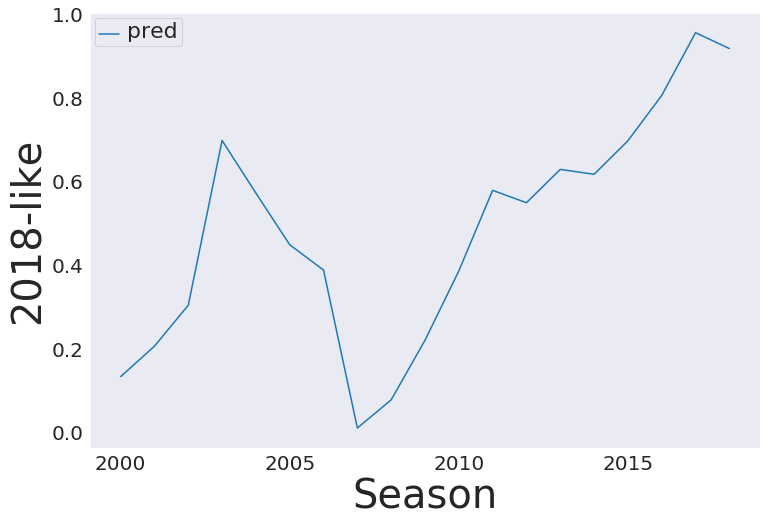

In [27]:
p = pred_df[['sea','pred']].set_index('sea').plot(figsize=(12, 8))
p.set_xlabel("Season")
p.set_ylabel("2018-like")
format_plot(p)


Next steps:

1. Extend analysis to multiple teams 
2. Rework LR to predict 3pt shooting trends, vs 2pt FGA in the future, this will be useful for teams trying to break trends and find the "best shot"